# Performance curves

In this notebook we will show how to compute performance curves (ROC and PR curves to be specific) given only positive and unlabeled data.

We will show several results:
- the true curves rank, assuming all labels are known
- the curves that would be obtained by treating the unlabeled set as negative
- bounds on the performance curves given a correct estimate of the fraction of positives in the unlabeled set
- bounds on the performance curves given an interval estimate of the fraction of positives in the unlabeled set that is obtained by peeking at the labels of 300 unlabeled instances.

This notebook is intended to enable you to easily change the configuration of experiments, so feel free to make modifications where you see fit to see their effect.

In [1]:
import random
import operator as op
import optunity.metrics
import semisup_metrics as ss
import numpy as np
from matplotlib import pyplot as plt
import pickle
import csv
import util
%matplotlib inline

# Create or load data set
Generate simulated data or load the results of an experiment in an existing paper. Feel free to configure the code below as you please.

In [2]:
# fraction of positives/negatives that are known
# known_neg_frac == 0 implies PU learning
known_pos_frac = 0.1
known_neg_frac = 0.0

# load results from the paper?
# http://www.sciencedirect.com/science/article/pii/S0925231215001174
use_paper_data = True
dataset = 'covtype'
#dataset = 'sensit'

# generate a simulated data set (requires use_paper_data = False)
# number of instances per class
# the number of unlabeled instances depends on these settings + known_X_frac

# if we use a lot of data, computation times are a little long
# but the resulting estimates become excellent, which corroborates consistency
# num_pos = 20000
# num_neg = 100000 

# if you simulate a smaller data set you can see some effects better
# but estimated bounds will be much wider
# because the ECDF confidence interval becomes large
num_pos = 2000  
num_neg = 10000 
distid = 2  # can be 1, 2 or 3, these correspond to certain curves in ROC space

# generate rankings and label vectors and compute corresponding beta
# beta is based on known_pos_frac, known_neg_frac and the number of pos and negs
# labels is a list of {True, False, None}, where None indicates unlabeled
# true_labels is a list of {True, False}
if use_paper_data:
    labels, true_labels, decision_values, beta = util.load_dataset(dataset, 
                                                                   known_pos_frac,
                                                                   known_neg_frac)
else:
    labels, true_labels, decision_values, beta = util.simulate_data(distid, num_pos, num_neg,
                                                                    known_pos_frac,
                                                                    known_neg_frac)

## Data set characteristics

Known parameters:

In [3]:
print('total number of instances: \t %d' % len(labels))
print('number of known positives: \t %d' % len(list(filter(lambda x: x == True, labels))))
print('number of known negatives: \t %d' % len(list(filter(lambda x: x == False, labels))))
print('number of unlabeled instances: \t %d' % len(list(filter(lambda x: x == None, labels))))

total number of instances: 	 40000
number of known positives: 	 2000
number of known negatives: 	 0
number of unlabeled instances: 	 38000


Unknown parameters:

In [4]:
print('number of latent positives: \t %d' % len(list(filter(lambda x: x[0] == None and x[1] == True, zip(labels, true_labels)))))
print('number of latent negatives: \t %d' % len(list(filter(lambda x: x[0] == None and x[1] == False, zip(labels, true_labels)))))
print('beta: \t %1.4f' % beta)

number of latent positives: 	 18000
number of latent negatives: 	 20000
beta: 	 0.4737


# Estimate beta

This step can be avoided if sufficient domain knowledge exist to guesstimate beta, or when using data-driven approaches as mentioned in the paper. 

In this notebook we use a point estimate you can provide (\hat{beta} in the paper). Change this parameter to see its effect in the figures later on. Additionally, we will perform Bayesian inference on beta by peeking at the true label of some unlabeled instances, as described in Section 6.3.

In [5]:
betahat = beta

print('true value of beta\t%1.4f' % beta)
print('point estimate of beta\t%1.4f' % betahat)

true value of beta	0.4737
point estimate of beta	0.4737


Alternatively, estimate beta by peeking at the latent labels of a few unlabeled instances. This corresponds to Section 6.3 in the manuscript.

In [6]:
# determine the latent labels (requires manual labeling in practice)
latent_labels = [true_label for label, true_label in zip(labels, true_labels) if label is None]

# we will peek at 300 labels to estimate beta based on a 95% credible interval
num_peeks = 300
credible_interval_length = 0.95

# peek at the true label of a subset of unlabeled instances
unlabeled_ranks = [idx for idx, lab in enumerate(labels) if lab == None]
sample = np.random.choice(unlabeled_ranks, num_peeks, replace=False)
sample_labels = [true_labels[i] for i in sample]
npos = sum(sample_labels)
nneg = sample.size - npos

# compute interval based on the percentile function of the posterior
beta_interval_ppf = ss.estimate_beta_by_labeling(npos, nneg, credible_interval_length, HPD=False)
print('Credible interval via PPF: %1.4f <= beta <= %1.4f.' % (beta_interval_ppf.lower, beta_interval_ppf.upper))
print("Width of credible interval based on PPF: %1.5f.\n" % (beta_interval_ppf.upper - beta_interval_ppf.lower))

# compute interval based on the highest posterior density region (shorter)
beta_interval_hpd = ss.estimate_beta_by_labeling(npos, nneg, credible_interval_length, HPD=True)
print('Credible interval via HPD: %1.4f <= beta <= %1.4f.' % (beta_interval_hpd.lower, beta_interval_hpd.upper))
print("Width of credible interval based on HPD: %1.5f." % (beta_interval_hpd.upper - beta_interval_hpd.lower))

# continue with beta based on HPD, because this is the shortest credible interval
# note that the coverage of both intervals is equal to credible_interval_length
beta_interval = beta_interval_hpd

Credible interval via PPF: 0.3947 <= beta <= 0.5066.
Width of credible interval based on PPF: 0.11196.

Credible interval via HPD: 0.3947 <= beta <= 0.5066.
Width of credible interval based on HPD: 0.11196.


# 1. Compute cumulative rank distribution of known positives

In [7]:
# sort the labels in descending order of corresponding decision values
sort_labels, sort_dv, sort_true_labels = zip(*sorted(zip(labels, decision_values, true_labels),
                                                     key=op.itemgetter(1), reverse=True))

# ranks of the known positives
known_pos_ranks = [idx for idx, lab in enumerate(sort_labels) if lab]

# compute rank ECDF of known positives
known_pos_ecdf = ss.compute_ecdf_curve(known_pos_ranks)

Next, we determine a confidence interval on the rank CDF of known positives. We can do this in several ways, our code provides a bootstrap approach and a method based on the Dvoretzky–Kiefer–Wolfowitz (DKW) inequality. Feel free to experiment.

In [8]:
ci_width = 0.95      # width of the confidence band on ECDF to be used
use_bootstrap = True # use bootstrap to compute confidence band
nboot = 2000         # number of bootstrap iterations to use, not used if use_bootstrap = False

if use_bootstrap:
    cdf_bounds = ss.bootstrap_ecdf_bounds(labels, decision_values, nboot=nboot, ci_width=ci_width)
else:
    cdf_bounds = ss.dkw_bounds(labels, decision_values, ci_width=ci_width)

For reference, we will also compute the rank ECDF of latent positives. In practical applications this is impossible, as the latent positives are by definition not known.

In [9]:
latent_positives = map(lambda x, y: x == True and y == None, true_labels, labels)
sort_lps, _ = zip(*sorted(zip(latent_positives, decision_values),
                          key=op.itemgetter(1), reverse=True))
latent_pos_ranks = [idx for idx, lab in enumerate(sort_lps) if lab]
latent_pos_ecdf = ss.compute_ecdf_curve(latent_pos_ranks)

Plot the rank CDFs of known and latent positives. It may occur that the rank CDF of latent positives is not within the confidence interval of known positives, in which case the corresponding bounds on performance will not be strict.

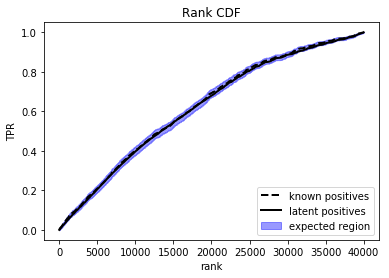

In [10]:
# convenience plot functions
def plot_proxy():
    p = plt.Rectangle((0, 0), 0, 0, color='blue', alpha=0.4)
    ax = plt.gca()
    ax.add_patch(p)
    return p

def fix_plot_shape(fig):
    ax = fig.add_subplot(111, aspect='equal')
    axes = fig.gca()
    axes.set_xlim([0,1])
    axes.set_ylim([0,1])

xs = list(range(len(labels)))
plt.figure(1)
plt.fill_between(xs, list(map(cdf_bounds.lower, xs)), list(map(cdf_bounds.upper, xs)), 
                 color='blue', alpha=0.4)
plt.plot(*zip(*known_pos_ecdf), color='black', linestyle='dashed', linewidth=2)
plt.plot(*zip(*latent_pos_ecdf), color='black', linewidth=2)
plot_proxy()
plt.xlabel('rank')
plt.ylabel('TPR')
plt.legend(['known positives', 'latent positives', 'expected region'], loc=4)
plt.title('Rank CDF')
plt.show()

# 2. Compute contingency tables for each rank
These tables are computed based on estimate of beta and the rank CDF of known positives. We will show the results for betahat and a the Bayesian credible interval on beta.

In [11]:
# first, compute contingency tables based on the point estimate betahat
# presorted = True is a computational shortcut
# we can use this because we already sorted by decision values earlier
tables_point = ss.compute_contingency_tables(labels=sort_labels, decision_values=sort_dv,
                                             reference_lb=cdf_bounds.lower,
                                             reference_ub=cdf_bounds.upper,
                                             beta=betahat, presorted=True)

# second, compute contingency tables based on the credible interval 
# we start with a convenience function for readability
compute_tables = lambda beta: ss.compute_contingency_tables(labels=sort_labels, decision_values=sort_dv,
                                                   reference_lb=cdf_bounds.lower,
                                                   reference_ub=cdf_bounds.upper,
                                                   beta=beta, 
                                                   presorted=True)

# tables based on lower bound on beta, only lower bound tables are to be used
tables_interval_lb = compute_tables(beta_interval.lower)
# tables based on upper bound on beta, only upper bound tables are to be used
tables_interval_ub = compute_tables(beta_interval.upper)
# merge into a single variable
# ss._lb_ub is a collections.namedtuple with fields 'lower' and 'upper'
tables_interval = ss._lb_ub(lower=tables_interval_lb.lower, upper=tables_interval_ub.upper)

# 3. Compute and plot performance estimates based on the contingency tables

## 3.1 ROC curves

Start off with the easy stuff: the true ROC curve (unknown in practice), and the curve we obtain by assuming beta=0.

In [12]:
# compute the true ROC curve (we use Optunity's ROC function)
_, roc_true = optunity.metrics.roc_auc(true_labels, decision_values, return_curve=True)
# compute the ROC curve that would be obtained by treating all unlabeled as negative
_, roc_neg = optunity.metrics.roc_auc(labels, decision_values, return_curve=True)

Compute bounds based on the proposed method.

In [13]:
# we can directly use the contingency tables we already computed anyways
roc_bounds = lambda tables: ss._lb_ub(lower=ss.roc_from_cts(tables.lower),
                                      upper=ss.roc_from_cts(tables.upper))
roc_bounds_point = roc_bounds(tables_point)
roc_bounds_interval = roc_bounds(tables_interval)

# an alternative without all these intermediate steps would be:
# roc_bounds_point = ss.roc_bounds(labels, decision_values, beta=betahat)

Finally, what if we would compute bounds on the labeled instances and the ones we peeked at to estimate beta? The indices of the random sample of unlabeled data we peeked at is in sample.

In [14]:
# labels and decision values of peeked instances in sample_labels and sample_decision_values
sample_decision_values = [decision_values[i] for i in sample]

# labels and decision values of known instances before peeking
filtered = filter(lambda x: x[0] is not None, zip(labels, decision_values))
apriori_known_labels = list(map(op.itemgetter(0), filtered))
apriori_known_dvs = list(map(op.itemgetter(1), filtered))

# all known labels and decision values after peeking
all_known_labels = apriori_known_labels + sample_labels
all_known_dvs = apriori_known_dvs + sample_decision_values

# data statistics
print('total number of known positives after peeking:\t%d' % sum(all_known_labels))
print('total number of known negatives after peeking:\t%d' % (len(all_known_labels) - sum(all_known_labels)))

# compute the resulting ROC curve
_, roc_peek = optunity.metrics.roc_auc(all_known_labels, all_known_dvs, return_curve=True)

total number of known positives after peeking:	2135
total number of known negatives after peeking:	165


C:\Users\hdemeule\AppData\Local\Continuum\anaconda3\lib\site-packages\optunity\metrics.py:211: RuntimeWarning: invalid value encountered in true_divide
  return float(FP) / (FP + TN)


In [19]:
roc_peek

[(nan, 0.0),
 (nan, 0.0033333333333333335),
 (nan, 0.01),
 (nan, 0.016666666666666666),
 (nan, 0.023333333333333334),
 (nan, 0.03666666666666667),
 (nan, 0.043333333333333335),
 (nan, 0.06),
 (nan, 0.07666666666666666),
 (nan, 0.09333333333333334),
 (nan, 0.10333333333333333),
 (nan, 0.11666666666666667),
 (nan, 0.13666666666666666),
 (nan, 0.15),
 (nan, 0.17),
 (nan, 0.18666666666666668),
 (nan, 0.20333333333333334),
 (nan, 0.22333333333333333),
 (nan, 0.23666666666666666),
 (nan, 0.26),
 (nan, 0.27),
 (nan, 0.27666666666666667),
 (nan, 0.2866666666666667),
 (nan, 0.30666666666666664),
 (nan, 0.3333333333333333),
 (nan, 0.35333333333333333),
 (nan, 0.36666666666666664),
 (nan, 0.38333333333333336),
 (nan, 0.4),
 (nan, 0.4166666666666667),
 (nan, 0.43666666666666665),
 (nan, 0.47),
 (nan, 0.5133333333333333),
 (nan, 0.5333333333333333),
 (nan, 0.56),
 (nan, 0.5933333333333334),
 (nan, 0.6333333333333333),
 (nan, 0.6733333333333333),
 (nan, 0.6966666666666667),
 (nan, 0.7433333333333333

Plot the resulting curves

C:\Users\hdemeule\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


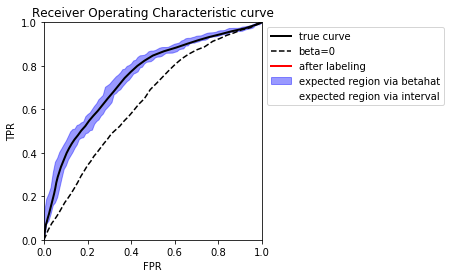

In [15]:
# convenience function for plot legend
def plot_proxy2():
    p = plt.Rectangle((0, 0), 0, 0, color='none', 
                      edgecolor='red', hatch='xxx', alpha=0.8)
    ax = plt.gca()
    ax.add_patch(p)
    return p

xs = [float(x) / 100 for x in range(101)]
roc_point_up = ss.zoh(*zip(*roc_bounds_point.upper))
roc_point_lo = ss.zoh(*zip(*roc_bounds_point.lower))
roc_interval_up = ss.zoh(*zip(*roc_bounds_interval.upper))
roc_interval_lo = ss.zoh(*zip(*roc_bounds_interval.lower))
fig = plt.figure(2)
fix_plot_shape(fig)
plt.plot(*zip(*roc_true), color='black', linewidth=2)
plt.fill_between(xs, list(map(roc_point_lo, xs)), list(map(roc_point_up, xs)), color='blue', alpha=0.4)
plt.fill_between(xs, list(map(roc_interval_lo, xs)), list(map(roc_interval_up, xs)), 
                 color='none', edgecolor='red', alpha=0.8, hatch='xxx')
plt.plot(*zip(*roc_neg), color='black', linestyle='dashed')
plt.plot(*zip(*roc_peek), color='red', linestyle='solid', linewidth=2)
plot_proxy()
plot_proxy2()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(['true curve', 'beta=0', 'after labeling',
            'expected region via betahat', 'expected region via interval'],
           loc="upper left", bbox_to_anchor=(1,1))
plt.title('Receiver Operating Characteristic curve')
plt.show()

Including the resulting ROC curve based on the peeked data.

## 3.2 PR curves

In [16]:
# we can directly use the contingency tables we already computed anyways
pr_bounds = lambda tables: ss._lb_ub(lower=ss.pr_from_cts(tables.lower),
                                      upper=ss.pr_from_cts(tables.upper))
pr_bounds_point = pr_bounds(tables_point)
pr_bounds_interval = pr_bounds(tables_interval)

# an alternative without all these intermediate steps would be:
# roc_bounds_point = ss.roc_bounds(labels, decision_values, beta=betahat)

# compute the true ROC curve (we use Optunity's ROC function)
_, pr_true = optunity.metrics.pr_auc(true_labels, decision_values, return_curve=True)
# compute the ROC curve that would be obtained by treating all unlabeled as negative
_, pr_neg = optunity.metrics.pr_auc(labels, decision_values, return_curve=True)

In [17]:
# PR curve based on all known labels after labeling 300 unlabeled instances
# we compute this by constructing the PR curve with weighted instances
# the weighting is used to fix the empirical class contributions to our estimate of beta

# compute the weight
npos_prior = len(list(filter(lambda x: x == True, labels)))
neg_weight = float(npos + npos_prior) / npos
print("Normalizing weight for negatives: %1.3f" % neg_weight)

all_known_labels, all_known_dvs
all_known_labels_sorted, _ = zip(*sorted(zip(all_known_labels, all_known_dvs),
                                         key=op.itemgetter(1), reverse=True))
known_after_labeling_cts = ss.compute_labeled_cts(all_known_labels_sorted)

# weigh contingency tables
weighted_cts = map(lambda ct: ss.ContingencyTable(TP=ct.TP, FN=ct.FN,
                                               FP=ct.FP * neg_weight,
                                               TN=ct.TN * neg_weight),
                   known_after_labeling_cts)
pr_after_labeling = ss.pr_from_cts(weighted_cts)

Normalizing weight for negatives: 15.815


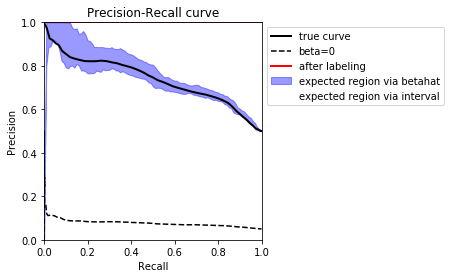

In [18]:
pr_point_up = ss.zoh(*zip(*pr_bounds_point.upper))
pr_point_lo = ss.zoh(*zip(*pr_bounds_point.lower))
pr_interval_up = ss.zoh(*zip(*pr_bounds_interval.upper))
pr_interval_lo = ss.zoh(*zip(*pr_bounds_interval.lower))
fig = plt.figure(3)
fix_plot_shape(fig)
plt.plot(*zip(*pr_true), color='black', linewidth=2)
plt.plot(*zip(*pr_neg), color='black', linestyle='dashed')
plt.fill_between(xs, list(map(pr_point_lo, xs)), list(map(pr_point_up, xs)), color='blue', alpha=0.4)
plt.fill_between(xs, list(map(pr_interval_lo, xs)), list(map(pr_interval_up, xs)), 
                 color='none', edgecolor='red', alpha=0.8, hatch='xxx')
plt.plot(*zip(*pr_after_labeling), color='red', linestyle='solid', linewidth=2)
plot_proxy()
plot_proxy2()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(['true curve', 'beta=0', 'after labeling',
            'expected region via betahat', 'expected region via interval'], 
           loc="upper left", bbox_to_anchor=(1,1))
plt.title('Precision-Recall curve')
plt.show()